In [ ]:
"""!pip install fancyimpute==0.7.0
!pip install imblearn==0.0
!pip install joblib==1.0.1
!pip install matplotlib==3.3.4
!pip install numpy==1.19.5
!pip install pandas==1.3.5
!pip install scikit_learn==0.24.2
!pip install scipy==1.6.2
!pip install seaborn==0.11.1
!pip install six==1.15.0
!pip install xgboost==1.5.1"""

  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:
from fancyimpute import KNN, SoftImpute

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression,RidgeClassifier, PassiveAggressiveClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib

%matplotlib inline


In [ ]:
import operator

In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [ ]:
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [ ]:
from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:

def classify(est, x, y,X_test,y_test):
    #Passing the model and train test dataset to fit the model
    est.fit(x, y)
    #Predicting the probabilities of the Tet data
    y2 = est.predict_proba(X_test)
    y1 = est.predict(X_test)

    print("Accuracy: ", metrics.accuracy_score(y_test, y1))
    print("Area under the ROC curve: ", metrics.roc_auc_score(y_test, y2[:, 1]))
    #Calculate different metrics
    print("F-metric: ", metrics.f1_score(y_test, y1))
    print(" ")
    print("Classification report:")
    print(metrics.classification_report(y_test, y1))
    print(" ")
    print("Evaluation by cross-validation:")
    print(cross_val_score(est, x, y))
    
    return est, y1, y2[:, 1]


#Function to find which features are more important than others through model
def feat_importance(estimator):
    feature_importance = {}
    for index, name in enumerate(df_LC.columns):
        feature_importance[name] = estimator.feature_importances_[index]

    feature_importance = {k: v for k, v in feature_importance.items()}
    sorted_x = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse = True)
    
    return sorted_x

#Model to  predict the ROC curve for various models and finding the best one
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            #'GaussianNB': GaussianNB(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10),
            'XGBClassifier': XGBClassifier()
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

In [ ]:
#Importing the datasets
data =pd.read_csv("https://s3.amazonaws.com/hackerday.datascience/358/LoansTrainingSetV2.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.head()
len(data)

111107

In [ ]:
##Drop the duplicates with respect to LOAN ID
data.drop_duplicates(subset="Loan ID",keep='first',inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


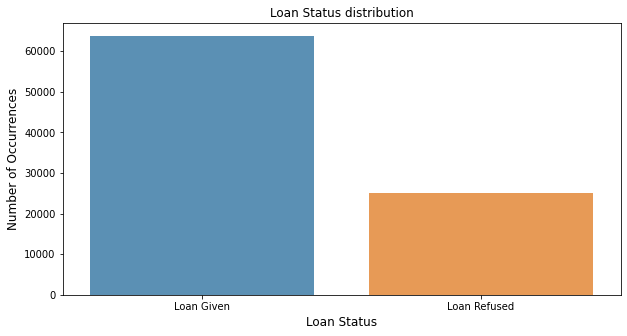

In [ ]:
##########PLotting the loan status 
status=data["Loan Status"].value_counts() 

plt.figure(figsize=(10,5))
sns.barplot(status.index, status.values, alpha=0.8)
plt.title('Loan Status distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Status', fontsize=12)
plt.show()

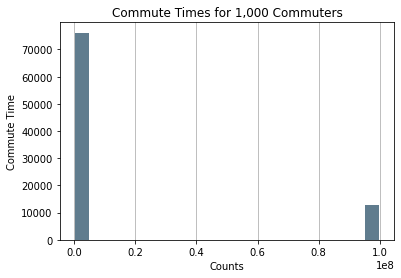

In [ ]:
###Current Loan Amount ############
data["Current Loan Amount"].describe()


data["Current Loan Amount"].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)


In [ ]:
#Finding IQR's for outlier removal

Q1 = data["Current Loan Amount"].quantile(0.25)
Q3 = data["Current Loan Amount"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

16202.0


In [ ]:
data["Current Loan Amount"][((data["Current Loan Amount"] < (Q1 - 1.5 * IQR)) |(data["Current Loan Amount"] > (Q3 + 1.5 * IQR)))]


5044     99999999
5045     99999999
5046     99999999
5047     99999999
5048     99999999
           ...   
17777    99999999
17778    99999999
17779    99999999
17780    99999999
17781    99999999
Name: Current Loan Amount, Length: 12738, dtype: int64

In [ ]:
temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount_temp"] = np.where(temp > 9999998, 'NaN', temp).tolist()


count    76172.000000
mean     13933.915756
std       8235.921922
min        491.000000
25%       7810.000000
50%      12038.000000
75%      19351.000000
max      35875.000000
Name: Current Loan Amount_temp, dtype: float64

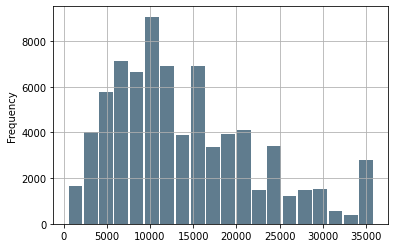

In [ ]:
temp=data["Current Loan Amount_temp"][data["Current Loan Amount_temp"]!='NaN'].astype(str).astype(int)
temp.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
                   
temp.describe()


In [ ]:
#Replacing the data with 50% percentile or mean
temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount"] = np.where(temp > 9999998,12038,temp).tolist()

data=data.drop(['Current Loan Amount_temp'],axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


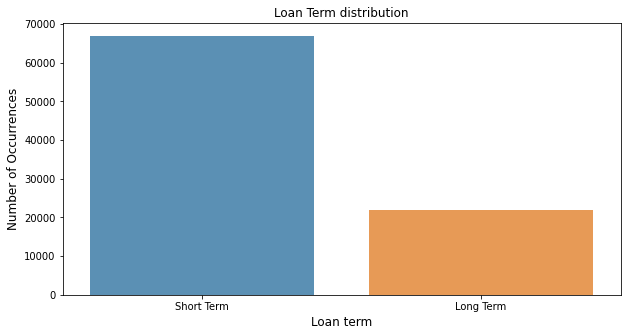

In [ ]:

############Term ##############

status=data["Term"].value_counts() 

plt.figure(figsize=(10,5))
sns.barplot(status.index, status.values, alpha=0.8)
plt.title('Loan Term distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan term', fontsize=12)
plt.show()


{'boxes': [<matplotlib.lines.Line2D at 0x7f0dc2dd3690>],
 'caps': [<matplotlib.lines.Line2D at 0x7f0dc20eb290>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0dc20ebf10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f0dc20eb8d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f0dc2dd3c50>,
  <matplotlib.lines.Line2D at 0x7f0dc2dd3490>]}

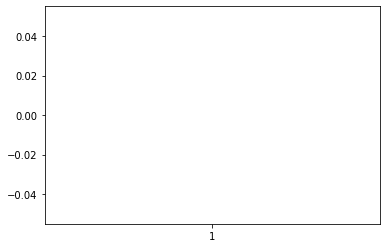

In [ ]:
#####Credit Score#############

data["Credit Score"].describe()
##Max is 7510. It should be between 0-800
plt.boxplot(data["Credit Score"])


In [ ]:
data["Credit Score"].isnull().sum()


21338

In [ ]:
#Now lets do treatment of the data at hand. Let us firstly divide the values greater than 800 by 10

data["Credit Score"]=np.where(data["Credit Score"]>800, data["Credit Score"]/10, data["Credit Score"])


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Credit Score_1', ylabel='Density'>

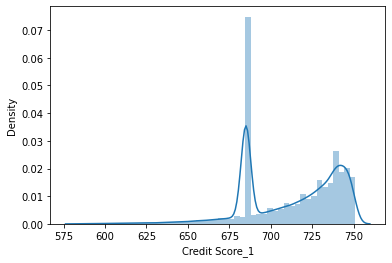

In [ ]:
#Now lets replace the missing values with median 
median_score=statistics.median(data["Credit Score"])

data["Credit Score_1"]=data["Credit Score"]
data["Credit Score_1"].fillna(median_score, inplace = True) 

sns.distplot(data["Credit Score_1"])


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Credit Score', ylabel='Density'>

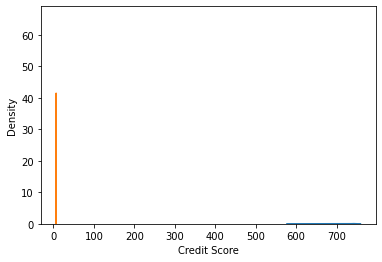

In [ ]:
#As we can see this data is skewed so when we replace it with median it is giving us problems. 
#Replacing with 75th percentile and taking log we get a better distribution


data["Credit Score"].fillna(741, inplace = True) 

sns.distplot(data["Credit Score"])
sns.distplot(np.log(data["Credit Score"]))

In [ ]:
data['Home Ownership'].unique()
#As we can see it has Home Mortgage and haveMortgage as 2 different classes. Lets fix that


array(['Rent', 'Home Mortgage', 'Own Home', 'HaveMortgage'], dtype=object)

In [ ]:
data['Home Ownership']=data['Home Ownership'].str.replace('HaveMortgage', 'Home Mortgage', regex=True)

data['Home Ownership'].unique()


array(['Rent', 'Home Mortgage', 'Own Home'], dtype=object)

In [ ]:
##################Annual Income######################
data['Annual Income'].describe()


count    6.757200e+04
mean     7.234575e+04
std      5.836101e+04
min      4.033000e+03
25%      4.458600e+04
50%      6.149400e+04
75%      8.675025e+04
max      8.713547e+06
Name: Annual Income, dtype: float64

In [ ]:
##Lets look at the quantiles of this columns

data['Annual Income'].quantile([.2,0.75,0.90,.95,0.99,.999])


0.200     40764.00
0.750     86750.25
0.900    119916.00
0.950    147645.00
0.990    239286.96
0.999    491575.77
Name: Annual Income, dtype: float64

In [ ]:
#As we can see they lie in the 99th percentile of the data.Lets replace them
# Capping any values greater than 99% to 99th value
data.loc[data['Annual Income'] > 239287, 'Annual Income'] = 239287


data['Annual Income'].isna().sum()
#So we have about 21000 null values 

##We will impute the mising data with other columns towards the end


21338

In [ ]:


###############Loan Purpose ###############

data['Purpose'].value_counts()
#So other and Other mean the same thing. Lets make it the same


Debt Consolidation      70447
Home Improvements        5206
other                    4917
Other                    2850
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

In [ ]:
data['Purpose']=data['Purpose'].str.replace('Other', 'other', regex=True)

In [ ]:
#######Monthly debt ###############


data['Monthly Debt'].describe()
##So this is not numeric column. Lets explore


count     88910
unique    76609
top           0
freq         55
Name: Monthly Debt, dtype: object

In [ ]:
data['Monthly Debt'] 
# But this should be a numeric column. So lets convert it to float


0         777.39
1         892.09
2        1244.02
3         990.94
4         503.71
          ...   
88905     567.62
88906    2508.63
88907      818.2
88908     360.17
88909     749.13
Name: Monthly Debt, Length: 88910, dtype: object

In [ ]:
#pd.to_numeric(data['Monthly Debt'] )
#As we can see there is a $ symbol present. Lets replace it 


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Monthly Debt', ylabel='Density'>

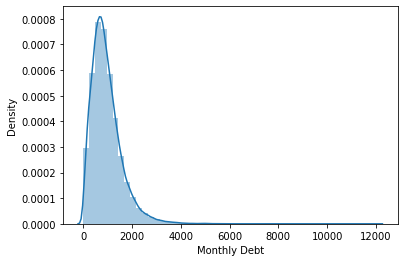

In [ ]:
data['Monthly Debt']=data['Monthly Debt'].str.replace('$', '', regex=True)

data['Monthly Debt']=pd.to_numeric(data['Monthly Debt'] )

sns.distplot(data["Monthly Debt"])


In [ ]:
#We can see that there are outliers in this data because of the plot
#Lets explore

data['Monthly Debt'].describe()
#The max value is too high here


count    65536.000000
mean       962.406632
std        632.799593
min          0.000000
25%        532.250000
50%        843.770000
75%       1251.342500
max      12055.680000
Name: Monthly Debt, dtype: float64

In [ ]:
data['Monthly Debt'].quantile([.2,0.75,0.90,.95,0.99,.999])


0.200     464.21000
0.750    1251.34250
0.900    1740.35000
0.950    2112.21000
0.990    3084.08600
0.999    4927.21625
Name: Monthly Debt, dtype: float64

In [ ]:
#Problem is with 99th percentile. lets dig deeper

data['Monthly Debt'].quantile([0.9995,.9999])
#So problem again is wit 99th percentile


0.9995    5513.352425
0.9999    7719.187600
Name: Monthly Debt, dtype: float64

In [ ]:
data['Monthly Debt'].quantile([0.9997,.99999])
#0.99970     5978.574911
#0.99999    13262.762330


0.99970     5979.063765
0.99999    11253.511940
Name: Monthly Debt, dtype: float64

In [ ]:
data['Monthly Debt'].quantile([0.999,1])


0.999     4927.21625
1.000    12055.68000
Name: Monthly Debt, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Monthly Debt', ylabel='Density'>

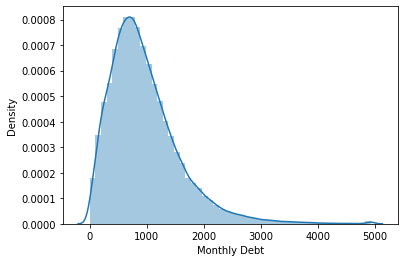

In [ ]:
#Need to replace this
data.loc[data['Monthly Debt'] > 4926, 'Monthly Debt'] = 4926

sns.distplot(data["Monthly Debt"])
#Now we get the right distribution


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Years of Credit History', ylabel='Density'>

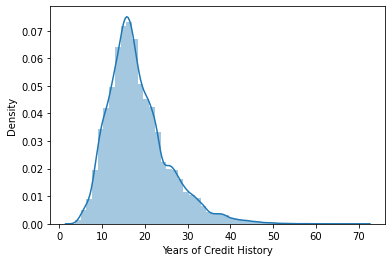

In [ ]:
####################Years of credit history #################

data['Years of Credit History'].value_counts()


sns.distplot(data["Years of Credit History"])
#Over all looks pretty clean! no need of doing anything


In [ ]:
#############Months since last delinquent####################

data['Months since last delinquent'].describe()


count    40404.000000
mean        35.080289
std         22.008583
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months since last delinquent, dtype: float64

In [ ]:
#Lets check if there are any NA's
data['Months since last delinquent'].isna().sum()
#We have nearly 48506 NA;s. We will try to handle them at last 


48506

In [ ]:
##############Number of open accounts ##############

data['Number of Open Accounts'].describe()
#The max number seems odd. Lets investigate


count    88910.000000
mean        11.110348
std          4.978461
min          0.000000
25%          8.000000
50%         10.000000
75%         14.000000
max         76.000000
Name: Number of Open Accounts, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Number of Open Accounts', ylabel='Density'>

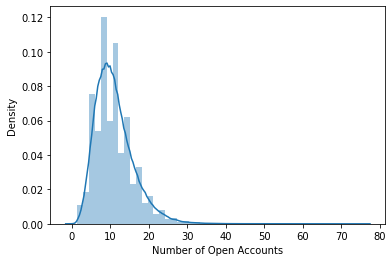

In [ ]:
sns.distplot(data['Number of Open Accounts'])
#Yes there are outliers in this columns. Let dig deeper


In [ ]:
data['Number of Open Accounts'].quantile([0.75,0.999,1])
#Ok so replacing anything greater than 99th percentile with 99th percentile values


0.750    14.0
0.999    36.0
1.000    76.0
Name: Number of Open Accounts, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Number of Open Accounts', ylabel='Density'>

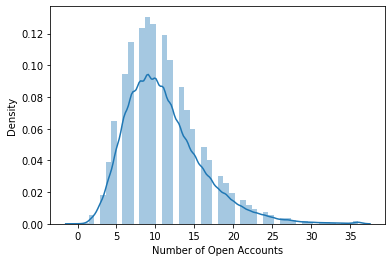

In [ ]:
data.loc[data['Number of Open Accounts'] > 36, 'Number of Open Accounts'] = 36


sns.distplot(data['Number of Open Accounts'])
#Looks good now


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Number of Credit Problems', ylabel='Density'>

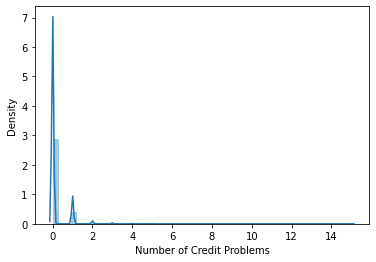

In [ ]:

#######################Number of Credit problems##############

data['Number of Credit Problems'].describe() 
#Max looks a bit higher. Lets see

sns.distplot(data['Number of Credit Problems'])


In [ ]:
#Okay lets look at value _counts


data['Number of Credit Problems'].value_counts()

#Okay looks good


0     77057
1     10271
2      1092
3       311
4       101
5        46
6        14
7         6
9         4
10        3
8         2
12        1
15        1
11        1
Name: Number of Credit Problems, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

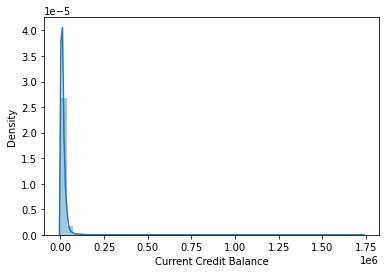

In [ ]:
##################Current Credit Balance###########

data['Current Credit Balance'].describe()

sns.distplot(data['Current Credit Balance'])
#It seems there are outliers in this data. Lets investigate


In [ ]:
data['Current Credit Balance'].quantile([0.75,0.95,0.999,1])


0.750      19301.000
0.950      39933.300
0.999     227670.033
1.000    1730472.000
Name: Current Credit Balance, dtype: float64

In [ ]:
#lets dig deeper

data['Current Credit Balance'].quantile([0.95,0.96,0.97,0.98,0.99,1])


0.95      39933.30
0.96      43501.20
0.97      48507.73
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

In [ ]:
#So lets replace it with 95th percentile

data['Current Credit Balance'].quantile([0.55,0.76,0.87,0.98,0.99,1])


0.55      12295.00
0.76      19805.84
0.87      27525.66
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

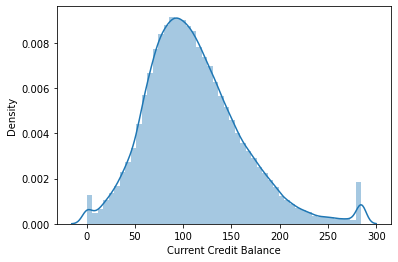

In [ ]:
data.loc[data['Current Credit Balance'] > 81007, 'Current Credit Balance'] = 81007


sns.distplot(data['Current Credit Balance']**(1/2))
#The plot doesnt look good. We need to transform it


In [ ]:
data['Current Credit Balance']=data['Current Credit Balance']**(1/2)


In [ ]:
#######################Max open credit################

data['Maximum Open Credit'].describe()


count     88910
unique    58216
top           0
freq        450
Name: Maximum Open Credit, dtype: object

In [ ]:
data['Maximum Open Credit'].value_counts()


0         450
0         160
15847       9
17464       9
6827        8
         ... 
28296       1
10199       1
132602      1
10395       1
21124       1
Name: Maximum Open Credit, Length: 58216, dtype: int64

In [ ]:
#sns.distplot(data['Maximum Open Credit'])
#So there are some str characters present in the data. Lets find them
#could not convert string to float: '#VALUE!'


In [ ]:
#pd.to_numeric(data['Maximum Open Credit'])
#Unable to parse string "#VALUE!" at position 4930

In [ ]:
#Lets replace #value with Nan
data['Maximum Open Credit']=data['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)


In [ ]:
data['Maximum Open Credit']=pd.to_numeric(data['Maximum Open Credit'])


In [ ]:
data['Maximum Open Credit'].isnull().sum()
#Now we have only 2 Nan;s in the data. Lets replace them with mean  


2

In [ ]:
data['Maximum Open Credit']=data['Maximum Open Credit'].fillna(35965)


In [ ]:
data['Maximum Open Credit'].quantile([0.55,0.76,0.87,0.98,0.99,1])



0.55       24037.95
0.76       37259.84
0.87       50736.66
0.98      114682.56
0.99      171423.91
1.00    69988086.00
Name: Maximum Open Credit, dtype: float64

In [ ]:
#Lets replace the outliers
data.loc[data['Maximum Open Credit'] > 171423, 'Maximum Open Credit'] = 171423


In [ ]:
###############Bankruptcies##########
data['Bankruptcies'].describe()


count    88718.000000
mean         0.112672
std          0.343300
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: Bankruptcies, dtype: float64

In [ ]:
data['Bankruptcies'].value_counts()


0.0    79323
1.0     8936
2.0      353
3.0       80
4.0       19
5.0        5
7.0        1
6.0        1
Name: Bankruptcies, dtype: int64

In [ ]:
data['Bankruptcies'].unique()

#So we have Nan's. Lets fill them with median


array([ 0.,  1., nan,  2.,  4.,  3.,  5.,  7.,  6.])

In [ ]:
data['Bankruptcies']=data['Bankruptcies'].fillna(3)


In [ ]:
####Tax Liens######

data['Tax Liens'].describe()


count    88902.000000
mean         0.028222
std          0.257533
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Tax Liens, dtype: float64

In [ ]:
data['Tax Liens'].value_counts()



0.0     87274
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
10.0        1
11.0        1
Name: Tax Liens, dtype: int64

In [ ]:
data['Bankruptcies'].unique()
###Looks good

array([0., 1., 3., 2., 4., 5., 7., 6.])

In [ ]:
cat_cols = ['Term','Years in current job','Home Ownership','Purpose']

for c in cat_cols:
    data[c] = pd.factorize(data[c])[0]

In [ ]:
#Imputing missing data with soft impute
updated_data=pd.DataFrame(data=SoftImpute().fit_transform(data[data.columns[3:19]],), columns=data[data.columns[3:19]].columns, index=data.index)
#Getting the dataset ready pd.get dummies function for dropping the dummy variables
df_LC = pd.get_dummies(updated_data, drop_first=True)

[SoftImpute] Max Singular Value of X_init = 23092221.868378
[SoftImpute] Iter 1: observed MAE=261.480152 rank=3
[SoftImpute] Iter 2: observed MAE=258.548469 rank=3
[SoftImpute] Iter 3: observed MAE=258.207662 rank=3
[SoftImpute] Iter 4: observed MAE=258.184852 rank=3
[SoftImpute] Iter 5: observed MAE=258.204643 rank=3
[SoftImpute] Iter 6: observed MAE=258.230069 rank=3
[SoftImpute] Iter 7: observed MAE=258.255573 rank=3
[SoftImpute] Iter 8: observed MAE=258.280106 rank=3
[SoftImpute] Iter 9: observed MAE=258.303449 rank=3
[SoftImpute] Iter 10: observed MAE=258.325504 rank=3
[SoftImpute] Iter 11: observed MAE=258.346214 rank=3
[SoftImpute] Iter 12: observed MAE=258.365509 rank=3
[SoftImpute] Iter 13: observed MAE=258.383517 rank=3
[SoftImpute] Iter 14: observed MAE=258.400220 rank=3
[SoftImpute] Iter 15: observed MAE=258.415645 rank=3
[SoftImpute] Iter 16: observed MAE=258.429899 rank=3
[SoftImpute] Iter 17: observed MAE=258.443135 rank=3
[SoftImpute] Iter 18: observed MAE=258.455321 ra

In [ ]:

#Binarizing the Target variable
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(data['Loan Status'])
y=lb_results
y=y.ravel()


#Scaling the independent variables
X_scaled = preprocessing.scale(df_LC)
print(X_scaled)
print('   ')
print(X_scaled.shape)


[[-0.1869176  -0.57302977  0.06886311 ... -0.79845518 -0.32295035
  -0.10958408]
 [ 1.48349848  1.74511004  0.26644983 ...  1.83825771 -0.32295035
  -0.10958408]
 [ 0.32079375 -0.57302977 -0.08920626 ... -0.53977375  2.39304617
  -0.10958408]
 ...
 [ 1.40247376 -0.57302977  0.78017528 ...  0.91232955 -0.32295035
  -0.10958408]
 [-1.1281112  -0.57302977 -0.16824094 ... -0.4039368  -0.32295035
  -0.10958408]
 [ 0.62515919 -0.57302977 -0.32631031 ... -0.30218149 -0.32295035
   3.77361205]]
   
(88910, 16)


In [ ]:
#######Looking at other models using different classifiers
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=22)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:58:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.7276646796385858
Area under the ROC curve:  0.7437786371367399
F-metric:  0.38419803323160395
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.83     18981
           1       0.55      0.29      0.38      7692

    accuracy                           0.73     26673
   macro avg       0.66      0.60      0.60     26673
weighted avg       0.70      0.73      0.70     26673

 
Evaluation by cross-validation:


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.73088046 0.73762853 0.73150157 0.73150157 0.72740419]
[0.15770203 0.25137326 0.16299246 0.02831689 0.04490009 0.04055737
 0.03080421 0.03046158 0.02761248 0.02706706 0.02785725 0.02524857
 0.03073877 0.03578309 0.03659303 0.0419918 ]


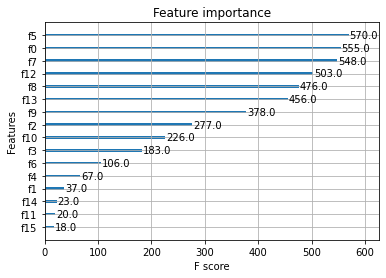

In [ ]:
#Finding accuracy and feature importance using XGB classifier
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(), X_train, y_train,X_test,y_test)
print(xgb0.feature_importances_)
plot_importance(xgb0)
pyplot.show()
feat1 = feat_importance(xgb0)


In [ ]:
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(n_estimators=47, learning_rate=0.015), X_train, y_train,X_test,y_test)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.7290893412814456
Area under the ROC curve:  0.7381679994031858
F-metric:  0.3351122561648877
 
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83     18981
           1       0.57      0.24      0.34      7692

    accuracy                           0.73     26673
   macro avg       0.66      0.58      0.58     26673
weighted avg       0.70      0.73      0.69     26673

 
Evaluation by cross-validation:


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.73666452 0.74116324 0.73608098 0.73664337 0.73013578]


In [ ]:
#######K nearest Neighbour classifier ################

knc, y_p, y_p2 = classify(KNeighborsClassifier(), X_train, y_train,X_test,y_test)


Accuracy:  0.6839500618603082
Area under the ROC curve:  0.6073078340129547
F-metric:  0.30992141453831046
 
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80     18981
           1       0.42      0.25      0.31      7692

    accuracy                           0.68     26673
   macro avg       0.58      0.55      0.55     26673
weighted avg       0.65      0.68      0.66     26673

 
Evaluation by cross-validation:
[0.69368573 0.69705977 0.69783884 0.69141159 0.68747489]


In [ ]:
########Logistic Regression ##############
logit, y_p, y_p2 = classify(LogisticRegression(), X_train, y_train,X_test,y_test)

Accuracy:  0.7201289693697747
Area under the ROC curve:  0.6722709585903062
F-metric:  0.21213720316622697
 
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83     18981
           1       0.56      0.13      0.21      7692

    accuracy                           0.72     26673
   macro avg       0.65      0.54      0.52     26673
weighted avg       0.68      0.72      0.65     26673

 
Evaluation by cross-validation:
[0.72606041 0.72919344 0.72812726 0.7282076  0.72684181]


In [ ]:
########Decision Tree Classifier ##########
dtc, y_p, y_p2 = classify(DecisionTreeClassifier(), X_train, y_train,X_test,y_test)

Accuracy:  0.6518576838000975
Area under the ROC curve:  0.5790952295591429
F-metric:  0.40282958199356916
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75     18981
           1       0.40      0.41      0.40      7692

    accuracy                           0.65     26673
   macro avg       0.58      0.58      0.58     26673
weighted avg       0.65      0.65      0.65     26673

 
Evaluation by cross-validation:
[0.65713368 0.65745501 0.65549932 0.66128384 0.65268739]


computing GradientBoosting - Non-balanced 
computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:02:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
computing XGBClassifier - Non-balanced 


,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,GradientBoosting,0.242773,0.753738,0.576281,0.250296,0.349008,Non-balanced
1,LogisticRegression,0.158180,0.672405,0.554031,0.127651,0.207495,Non-balanced
2,RandomForestClassifier,0.199133,0.701102,0.510873,0.244500,0.330720,Non-balanced
3,XGBClassifier,0.245700,0.743843,0.547578,0.290344,0.379477,Non-balanced


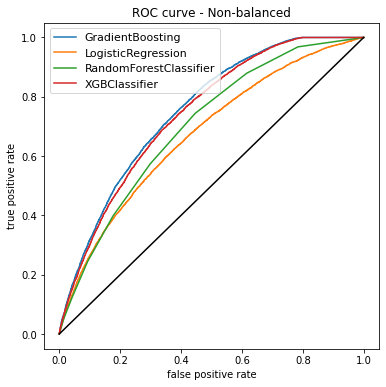

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
models_report

computing GradientBoosting - Balanced 
computing LogisticRegression - Balanced 
computing RandomForestClassifier - Balanced 


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:03:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
computing XGBClassifier - Balanced 


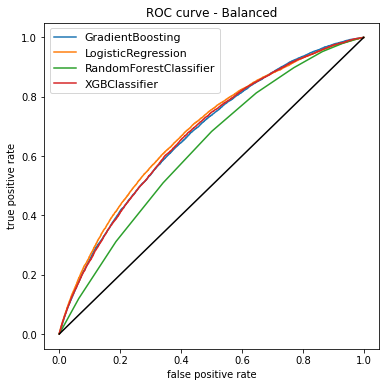

In [ ]:
###########Synthetically balancing the dataset##################
index_split = int(len(X_scaled)/2)
X_train, y_train = SMOTE().fit_resample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')

In [ ]:
################Now we  know that GBM model performed the best so 
# save model
gbm=GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3)
gbm.fit(X_scaled, y)
joblib.dump(gbm, 'GBM_Model_version1.pkl')
# load model
#gbm_pickle = joblib.load('GBM_Model_version1.pkl')

['GBM_Model_version1.pkl']